In [98]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


서로 다른 폴더에 있는 모듈들을 import하기 위해 절대경로를 sys.path에 추가해준다

In [99]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import torch
from MTL.model import resnet
import torchvision.transforms as transforms
from PIL import Image as im
import time

In [100]:
emo={0:'sad', 1:'happy', 2:'angry', 3:'disgust', 4:'surprise', 5:'fear', 6:'neutral'}
gender={0:'man',1:'woman'}

In [101]:
device='cuda:0'
model=YOLO('ultralytics/models/v8/yolov8s.yaml')
model=YOLO('weight/yolov8/s_best.pt')
model.device


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.Conv                  [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.C2f                   [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.Conv                  [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.C2f                   [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.Conv                  [256

device(type='cpu')

In [102]:
emotion_model=resnet.EmotionModel(phase='test')
state_dict=torch.load('weight/classification/emotion128_resnet18.pt')
emotion_model.load_state_dict(state_dict)
emotion_model.to(device)

EmotionModel(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [127]:

start_time=time.time()
result=model(source='11.png')
orig_img=result[0].orig_img
img=Image.fromarray(orig_img)
numpy_img=np.array(img)
opencv_img=cv2.cvtColor(numpy_img,cv2.COLOR_BGR2RGB)
boxes=result[0].boxes.xyxy.cpu().numpy()
for box in boxes:
    x1=int(box[0])
    y1=int(box[1])
    x2=int(box[2])
    y2=int(box[3])
    cv2.rectangle(opencv_img,(x1,y1),(x2,y2),(255,0,0),2)



if len(boxes)==0:
    print('no boxes')
else:
    orig_img=cv2.cvtColor(orig_img,cv2.COLOR_BGR2RGB)
    orig_faces=[]
    for box in boxes:
        x1=int(box[0])
        y1=int(box[1])
        x2=int(box[2])
        y2=int(box[3])
        crop_img=orig_img[y1:y2,x1:x2,:]
        resized_img=cv2.resize(crop_img,(128,128))
        orig_faces.append(resized_img)

    faces=np.array(orig_faces).astype(np.float32)/255.0
    faces=np.transpose(faces,(0,3,1,2))
    faces=torch.from_numpy(faces)
    normalize=transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    faces=normalize(faces)

    faces=faces.to(device)
    emotion_output=emotion_model(faces)
    pred=emotion_output.argmax(1,keepdim=True)
end_time=time.time()

    




image 1/1 /home/joowan/Desktop/face_pr/11.png: 352x640 24 faces, 5.4ms
Speed: 0.3ms preprocess, 5.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


In [128]:
print(end_time-start_time)
print(len(boxes))

0.0232546329498291
24


In [147]:
emo_dict={'sad':0,'happy':0,'angry':0,'disgust':0,'surprise':0,'fear':0,'neutral':0}
emo_labels=['sad','happy','angry','disgust','surprise','fear','neutral']
for i in range(len(orig_faces)):
    emo_dict[emo[pred[i].item()]]+=1
   
emo_ratio=list(emo_dict.values())  
print(emo_ratio!=0)

True


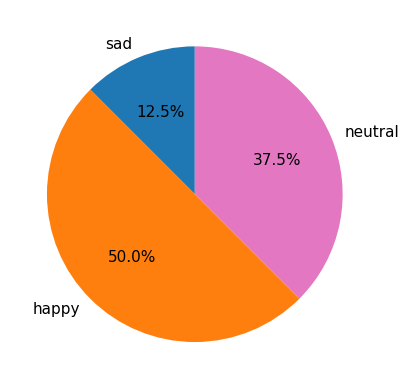

In [156]:
fig1,ax1=plt.subplots()
wedges, texts, autotexts = ax1.pie(emo_ratio,labels=['sad','happy','angry','disgust','surprise','fear','neutral'],autopct=lambda x: '{:.1f}%'.format(x) if x > 0 else '',startangle=90)
# Remove label for 0% value
for i, text in enumerate(texts):
    if emo_ratio[i] == 0:
        text.set_text('')   
             
plt.show()

In [ ]:
wedges, _, autotexts = ax.pie(values, labels=labels, autopct=lambda x: '{:.0f}%'.format(x) if x > 0 else '', startangle=90)

# Remove label for 0% value
for i, autotext in enumerate(autotexts):
    if values[i] == 0:
        autotext.set_text('')
        wedges[i].set_alpha(0)